In [1]:
%pip install scikit-learn seaborn dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
Note: you may need to restart the kernel to use updated packages.


In [2]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

print("总样本数:", len(data))
print("字段:", data.columns.tolist())
print(data['category'].value_counts())  # 看攻击类别分布


总样本数: 2934817
字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64


In [4]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [5]:
# data.drop(columns=['sport', 'dport'], inplace=True)

In [6]:
data.category.value_counts()

category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64

In [7]:
le = LabelEncoder()
le.fit_transform(data.category.values)
data['category'] = le.transform(data['category'])

In [8]:
data['category'].value_counts()

category
0    1541315
1    1320148
3      72919
2        370
4         65
Name: count, dtype: int64

In [9]:
le.fit_transform(data.proto.values)
data['proto'] = le.transform(data['proto'])

In [10]:
data['proto'].value_counts()

proto
4    1596819
3    1330598
1       7228
0        166
2          6
Name: count, dtype: int64

In [11]:
data['saddr'] = data.saddr.apply(str)
data['daddr'] = data.daddr.apply(str)

In [12]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [13]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [14]:
data.fillna(0,inplace = True)

In [15]:
# label_ground_truth = data[["saddr", "daddr","label"]]

In [16]:
data.drop(columns=['index'],inplace=True)

In [17]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [18]:
data

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,4,172.23.29.145,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,0,UDP
1,2432264,3,172.24.88.127,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,0,TCP
2,1976315,3,172.26.142.232,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,0,TCP
3,1240757,4,172.22.138.77,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,1,UDP
4,3257991,4,172.16.70.241,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,172.29.40.211,56044,192.168.100.5,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1,1,UDP
2934813,3384621,4,172.19.105.87,21546,192.168.100.3,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1,0,UDP
2934814,775893,4,172.25.0.253,30897,192.168.100.5,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1,1,UDP
2934815,443484,3,172.30.135.141,36904,192.168.100.7,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1,1,TCP


In [19]:
labels = data["category"]
labels

0          0
1          0
2          0
3          1
4          0
          ..
2934812    1
2934813    0
2934814    1
2934815    1
2934816    1
Name: category, Length: 2934817, dtype: int64

In [20]:

features = data.drop(columns=["category", "subcategory"])
features = features.drop(['saddr', 'daddr'], axis=1)
features

,pkSeqID,proto,sport,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,3142762,4,6551,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1
1,2432264,3,5532,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1
2,1976315,3,27165,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1
3,1240757,4,48719,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1
4,3257991,4,22461,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,56044,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1
2934813,3384621,4,21546,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1
2934814,775893,4,30897,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1
2934815,443484,3,36904,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1


In [21]:
print("字段:", features.columns.tolist())
print("Shape: ", features.columns.shape)

字段: ['pkSeqID', 'proto', 'sport', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack']
Shape:  (15,)


In [22]:
features.columns

Index(['pkSeqID', 'proto', 'sport', 'dport', 'seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max', 'attack'],
      dtype='object')

In [23]:
num_features = features.select_dtypes(include=[np.number])
features_array = num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
labels_array = labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [24]:
features_array.shape

(2934817, 13)

In [25]:
labels_array.shape

(2934817,)

In [26]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features_array)
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(standardized_data)

In [27]:
import torch
features_tensor = torch.tensor(normalized_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)  # 如果标签是整数型，可以使用 torch.long 类型

In [28]:
features_tensor = pd.concat([data[['saddr', 'daddr']].reset_index(drop=True), pd.DataFrame(features_tensor.numpy())], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    features_tensor, labels_tensor, test_size=0.3, random_state=42, stratify=labels_tensor)
train_ds = len(X_train)
val_ds = len(X_test)

In [30]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns)) - set(list(['label'])))
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])


In [31]:
X_train['label'] = y_train
X_train['h'] = X_train[cols_to_norm].values.tolist()

In [32]:
X_train

,saddr,daddr,0,1,2,3,4,5,6,7,8,9,10,11,12,label,h
1269757,172.22.70.213,192.168.100.3,1.114461,0.897310,0.040453,0.596270,-1.129841,0.649381,0.729236,1.108161,0.414864,-0.007007,-0.003602,1.003211,0.011229,0,"[1.1144609451293945, 0.8973104357719421, 0.040..."
790450,172.30.184.255,192.168.100.3,0.194802,-1.049335,0.082005,1.213193,0.715369,-0.685663,-0.112960,0.264031,0.414864,-0.007007,-0.005227,0.545601,0.011229,0,"[0.19480228424072266, -1.0493345260620117, 0.0..."
1803747,172.22.213.172,192.168.100.3,-0.286320,0.897310,0.081701,-1.080975,0.715369,2.540277,0.729236,1.696932,0.414864,-0.007007,-0.004442,0.975518,0.011229,1,"[-0.28632041811943054, 0.8973104357719421, 0.0..."
255752,172.16.169.6,192.168.100.5,-0.650617,0.897310,-1.550849,0.940323,0.715369,-0.685663,0.729236,-0.145793,0.414864,-0.007007,-0.005298,0.258790,0.011229,1,"[-0.6506170034408569, 0.8973104357719421, -1.5..."
2217926,172.19.56.240,192.168.100.3,-0.030006,-1.049335,0.398645,-1.103850,-0.760799,-0.685663,-0.112960,-1.469636,0.414864,-0.007007,-0.005763,-1.622541,0.011229,0,"[-0.030005862936377525, -1.0493345260620117, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282698,172.17.11.215,192.168.100.6,-1.566774,-1.049335,0.686212,-1.087024,-2.400985,-0.685663,-1.797353,-1.461168,-3.771075,-0.006333,-0.005496,-1.605537,0.011229,1,"[-1.566773533821106, -1.0493345260620117, 0.68..."
2020197,172.20.41.237,192.168.100.3,-0.165158,-1.049335,-1.489959,-1.103850,0.715369,-0.685663,-0.112960,-1.469636,0.414864,-0.007007,-0.005531,-1.622541,0.011229,0,"[-0.16515760123729706, -1.0493345260620117, -1..."
1618113,172.23.13.169,192.168.100.3,-0.894763,0.897310,-1.504403,1.128783,-0.350753,-0.685663,0.729236,0.894510,-1.017168,-0.007007,-0.004821,0.794233,0.011229,1,"[-0.8947626352310181, 0.8973104357719421, -1.5..."
1610257,172.27.224.66,192.168.100.3,0.048340,-1.049335,1.493445,-1.103850,0.305322,-0.454925,-1.797353,-1.244125,0.414864,-0.007007,0.000400,-1.438609,0.011229,0,"[0.04833989962935448, -1.0493345260620117, 1.4..."


In [33]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G, edge_attrs=['h', 'label'])

In [34]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [35]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [36]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

print(node_features.shape)
print(edge_features.shape)

torch.Size([861369, 1, 13])
torch.Size([4108742, 1, 13])


In [37]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

# --- 1. SAGELayer (Modified) ---
class SAGELayer(nn.Module):
    # edim是边的特征维度
    # ndim_in是输入节点特征维度
    # ndim_out是输出节点特征维度
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        
        # 消息函数 W_msg 接收拼接后的特征：源节点特征(ndim_in) + 边特征(edims)
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out) 
        
        # 激活函数
        self.activation = activation

        # 标准 GraphSAGE 的 'apply' 操作是拼接 self 和 neigh，然后进行线性变换
        # 我们这里使用 GAT/GCN 的简单方式：直接对聚合后的特征进行线性变换 (W_apply)
        # 如果使用'self-attention'，则需要增加一个针对 'h_self' 的变换，这里简化为只用聚合特征
        
        # 聚合后的特征维度就是 ndim_out
        # W_apply 接收聚合后的特征 (ndim_out)，并将其变换到最终的 ndim_out
        # 为了兼容原始代码中复杂的相加操作，我们将输出结果直接作为最终的特征
        self.W_apply = nn.Linear(ndim_out, ndim_out)

    # 消息函数: 拼接源节点特征和边特征
    def message_func(self, edges):
        # edges.src['h'] 是 [B, 1, F_src], edges.data['h'] 是 [B, 1, F_edge]
        
        # 1. 移除维度 1: [B, 1, F] -> [B, F]
        src_h = edges.src['h'].squeeze(1) # [B, ndim_in]
        edge_h = edges.data['h'].squeeze(1) # [B, edims]
        
        # 2. 拼接
        concatenated = th.cat([src_h, edge_h], dim=1) # [B, ndim_in + edims]
        
        # 3. 线性变换
        # 消息 'm' 的维度为 ndim_out
        return {'m': self.W_msg(concatenated).unsqueeze(1)} # 恢复 [B, 1, ndim_out] 形状

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            
            # 修正输入特征的形状: [N, 1, F] -> [N, F] 
            # DGL 的 ndata/edata 应该存储 [N, F]，但在 message_func/apply_edges 中使用时需要处理
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats

            # 聚合邻居节点特征
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))

            h_neigh = g.ndata['h_neigh'] # [N, 1, ndim_out]
            
            # W_apply操作: 移除维度1，进行线性变换，再恢复维度1
            h_neigh_squeezed = h_neigh.squeeze(1) # [N, ndim_out]
            
            # 核心 GraphSAGE 'apply' 步骤
            h_new = self.W_apply(h_neigh_squeezed) # [N, ndim_out]
            
            # 应用激活函数并恢复形状
            g.ndata['h'] = self.activation(h_new).unsqueeze(1) # [N, 1, ndim_out]

            return g.ndata['h']

# --- 2. SAGE (Simplified) ---
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        # 这里只保留一层 GNN，使其输出 ndim_out 维特征
        self.layers.append(SAGELayer(ndim_in, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                # Dropout 应该在 GNN 层之间作用于节点特征，这里只有一层，可忽略
                nfeats = self.dropout(nfeats) 
            nfeats = layer(g, nfeats, efeats)
            
        # 最终输出的形状是 [N, 1, ndim_out]，将其挤压为 [N, ndim_out]
        return nfeats.squeeze(1)


# --- 3. FullyConnectedPredictor (Modified) ---
class FullyConnectedPredictor(nn.Module):
    # in_features 是 GNN 层的输出维度 (ndim_out)
    def __init__(self, in_features, out_classes, edge_dim):
        super().__init__()
        
        # 边特征的预处理层: 原始维度 edge_dim -> 匹配节点特征维度 in_features
        self.fc_edge = nn.Linear(edge_dim, in_features)
        
        # 预测层: 接收 [源节点特征 + 目标节点特征 + 转换后的边特征]
        # 维度: in_features + in_features + in_features = 3 * in_features
        self.fc = nn.Linear(3 * in_features, out_classes)

    def apply_edges(self, edges):
        # 节点特征来自 GNN 输出，形状为 [B, in_features]
        h_u = edges.src['h'] # [B, in_features]
        h_v = edges.dst['h'] # [B, in_features]
        
        # 边特征来自原始输入，形状为 [B, 1, edge_dim]，需要修正
        h_e_raw = edges.data['h'].squeeze(1) # [B, edge_dim]
        
        # 转换边特征维度
        h_e_transformed = self.fc_edge(h_e_raw) # [B, in_features]
        
        # 拼接特征
        concatenated = th.cat([h_u, h_v, h_e_transformed], 1) # [B, 3 * in_features]
        
        # 预测分数
        score = self.fc(concatenated) # [B, out_classes]
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            # h 的形状是 [N, ndim_out]
            graph.ndata['h'] = h
            # 原始边特征 G.edata['h'] 已经在 main loop 中传入，这里直接使用
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [38]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(G.edata['label'].cpu().numpy()),
                                                  y=G.edata['label'].cpu().numpy())

class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss().cuda()
# criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

In [39]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [40]:
node_features = node_features.cuda()
edge_features = edge_features.cuda()
edge_label = edge_label.cuda()
train_mask = train_mask.cuda()
G = G.to('cuda')

In [41]:

# --- 4. Model and Training (Modified) ---
# 定义 GNN 的输入/输出维度
node_in_dim = node_features.shape[2]  # 13 (节点特征的最后一维)
edge_in_dim = edge_features.shape[2]  # 13 (边特征的最后一维)
gnn_out_dim = 128                     # GNN 输出特征维度
num_classes = 5                       # 预测的类别数量

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        # ndim_out 统一为 GNN 层的输出维度 (128)
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout) 
        
        # 预测器需要 GNN 输出的特征维度 (ndim_out) 和 原始的边特征维度 (edim)
        self.pred = FullyConnectedPredictor(ndim_out, num_classes, edim) 

    def forward(self, g, nfeats, efeats):
        # h 的形状是 [N, ndim_out]，即 [861438, 128]
        h = self.gnn(g, nfeats, efeats)
        
        # 预测器需要 g 和 h，同时将原始边特征 efeats 存储在 graph.edata['h'] 中供 apply_edges 使用
        # 注意: 边特征 efeats 必须作为原始数据传入，因为它在 apply_edges 中被再次访问
        return self.pred(g, h)

# 实例化模型
model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
).to('cuda')

# 优化器
opt = th.optim.Adam(model.parameters())

# 训练循环 (保持不变)
losses = []
accuracies = []

for epoch in range(1, 100):
    pred = model(G, node_features, edge_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 记录损失和准确率
    losses.append(loss.item())
    acc = compute_accuracy(pred[train_mask], edge_label[train_mask])
    accuracies.append(acc)

    if epoch % 1 == 0:
        # if epoch % 100 == 0:
        #     th.save(model.state_dict(), os.path.join('./model', 'epoch-{}.pt'.format(epoch)))
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Epoch: 1  Training acc: 0.29475104808807373
Epoch: 2  Training acc: 0.5519056916236877
Epoch: 3  Training acc: 0.7890598177909851
Epoch: 4  Training acc: 0.8457294702529907
Epoch: 5  Training acc: 0.8750876188278198
Epoch: 6  Training acc: 0.8924272060394287
Epoch: 7  Training acc: 0.9032400250434875
Epoch: 8  Training acc: 0.9099985361099243
Epoch: 9  Training acc: 0.9151214957237244
Epoch: 10  Training acc: 0.9193466305732727
Epoch: 11  Training acc: 0.9230935573577881
Epoch: 12  Training acc: 0.9264768362045288
Epoch: 13  Training acc: 0.9298002123832703
Epoch: 14  Training acc: 0.9327746033668518
Epoch: 15  Training acc: 0.9355418682098389
Epoch: 16  Training acc: 0.9380446076393127
Epoch: 17  Training acc: 0.9404708743095398
Epoch: 18  Training acc: 0.9427362680435181
Epoch: 19  Training acc: 0.9449875950813293
Epoch: 20  Training acc: 0.9469490051269531
Epoch: 21  Training acc: 0.9484962224960327
Epoch: 22  Training acc: 0.9494736194610596
Epoch: 23  Training acc: 0.9500979185104

In [42]:
import torch as th
import os

# 定义保存路径
MODEL_DIR = './saved_models'
MODEL_NAME = 'edge_predictor_sage_final.pt'
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

# 确保目录存在
os.makedirs(MODEL_DIR, exist_ok=True)

# 保存模型的状态字典
# model 是您训练好的 Model 实例
th.save(model.state_dict(), SAVE_PATH)

print(f"模型已成功保存到: {SAVE_PATH}")

模型已成功保存到: ./saved_models/edge_predictor_sage_final.pt


In [43]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

X_test['label'] = y_test
X_test['h'] = X_test[cols_to_norm].values.tolist()

G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test, edge_attrs=['h', 'label'])
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'],
                                     (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [44]:
import timeit
G_test = G_test.to('cuda')
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature'].cuda()
edge_features_test = G_test.edata['h'].cuda()
test_pred = model(G_test, node_features_test, edge_features_test).to('cuda')
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

0.08680303599976469 seconds


In [45]:
print("输出混淆矩阵")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, test_pred)
print(cm)

输出混淆矩阵
[[923648    235      0    907      0]
 [  5089 786983      0     18      0]
 [     0      0    220      2      0]
 [ 15494      0      0  28258      0]
 [     4      0      0     34      0]]


In [46]:
print("计算评价指标")
import numpy as np
# from tabulate import tabulate

conf_matrix = cm

# 计算评估指标
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall = np.mean(recall_per_class)
precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
class_counts = np.sum(conf_matrix, axis=1)
weighted_f1 = np.sum(f1_per_class * class_counts) / np.sum(class_counts)

table_data = []
for i in range(len(recall_per_class)):
    table_data.append([f"类别 {i}",
                       np.round(np.diag(conf_matrix)[i] / np.sum(conf_matrix[i]), 3),
                       np.round(recall_per_class[i], 3),
                       np.round(precision_per_class[i], 3),
                       np.round(f1_per_class[i], 3)])

table_data.append(["平均", np.round(accuracy, 3), np.round(recall, 3), np.round(np.mean(precision_per_class), 3),
                   np.round(weighted_f1, 3)])

headers = ["类别", "准确率", "召回率", "精确率", "加权平均F1值"]
# print(tabulate(table_data, headers=headers, floatfmt=".3f", tablefmt="pretty", numalign='center'))

print('over')

计算评价指标
over


/tmp/ipykernel_9202/1725162759.py:11: RuntimeWarning: invalid value encountered in divide
  precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)


target_names [0 1 2 3 4]


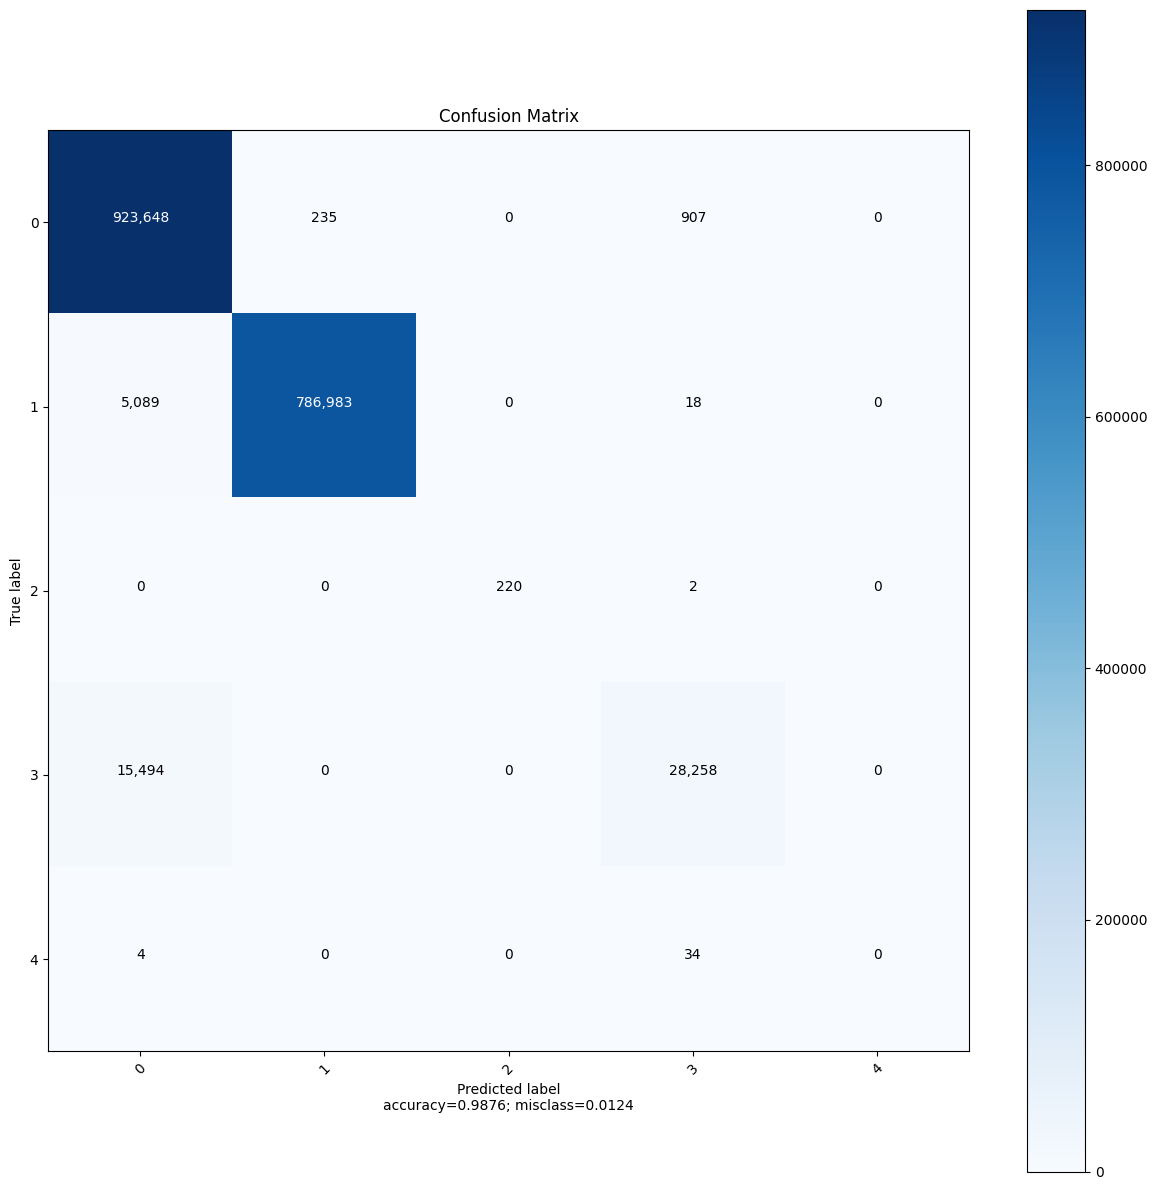

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packag

              precision    recall  f1-score   support

           0     0.9782    0.9988    0.9884    924790
           1     0.9997    0.9936    0.9966    792090
           2     1.0000    0.9910    0.9955       222
           3     0.9671    0.6459    0.7745     43752
           4     0.0000    0.0000    0.0000        38

    accuracy                         0.9876   1760892
   macro avg     0.7890    0.7258    0.7510   1760892
weighted avg     0.9876    0.9876    0.9867   1760892



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [47]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


from sklearn.metrics import confusion_matrix

print("target_names",np.unique(actual))
plot_confusion_matrix(cm=confusion_matrix(actual, test_pred),
                      normalize=False,
                      target_names=np.unique(actual),
                      title="Confusion Matrix")

from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))
report = classification_report(actual, test_pred, digits=4, output_dict=True)
df = pd.DataFrame(report).transpose()

In [48]:
# 假设您已经定义了 Model 类和所有必要的参数

# 重新定义模型参数 (必须与保存时一致)
node_in_dim =  # 假设是 35
edge_in_dim = 35 # 假设是 35
gnn_out_dim = 128
num_classes = 5

# 1. 实例化模型（使用与训练时相同的参数）
loaded_model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
)

# 2. 加载状态字典
# 如果模型训练时在 GPU 上，加载到 CPU 或当前设备：
loaded_model.load_state_dict(th.load(SAVE_PATH))

# 3. 将模型设置为评估模式（在进行推理或测试时非常重要）
loaded_model.eval() 

# 4. 如果需要在 GPU 上进行推理，请移动模型
# loaded_model.to('cuda')

SyntaxError: invalid syntax (2418971178.py, line 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [ ]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [ ]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [ ]:
G = G.to_directed()

In [ ]:
G = from_networkx(G,edge_attrs=['h','label'])

In [ ]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [ ]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1]) 

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [ ]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
G.ndata['h'].shape

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 6)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(G.edata['label'].cpu().numpy()),
#                                                  G.edata['label'].cpu().numpy())

import numpy as np
from sklearn.utils import class_weight

y = G.edata['label'].cpu().numpy()
classes = np.unique(y)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

In [ ]:
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
G = G.to('cpu')

In [ ]:
G.device

In [ ]:
G.ndata['h'].device  

In [ ]:
G.edata['h'].device  

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)

opt = th.optim.Adam(model.parameters())

for epoch in range(1,14500):
    pred = model(G, node_features,edge_features)
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    # if epoch % 100 == 0:
    print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

In [ ]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 55)

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [ ]:
G_test = G_test.to('cuda:0')

In [ ]:
th.cuda.empty_cache()

In [ ]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [ ]:
print(str(elapsed) + ' seconds')

In [ ]:
test_pred = test_pred.argmax(1)

In [ ]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [ ]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")